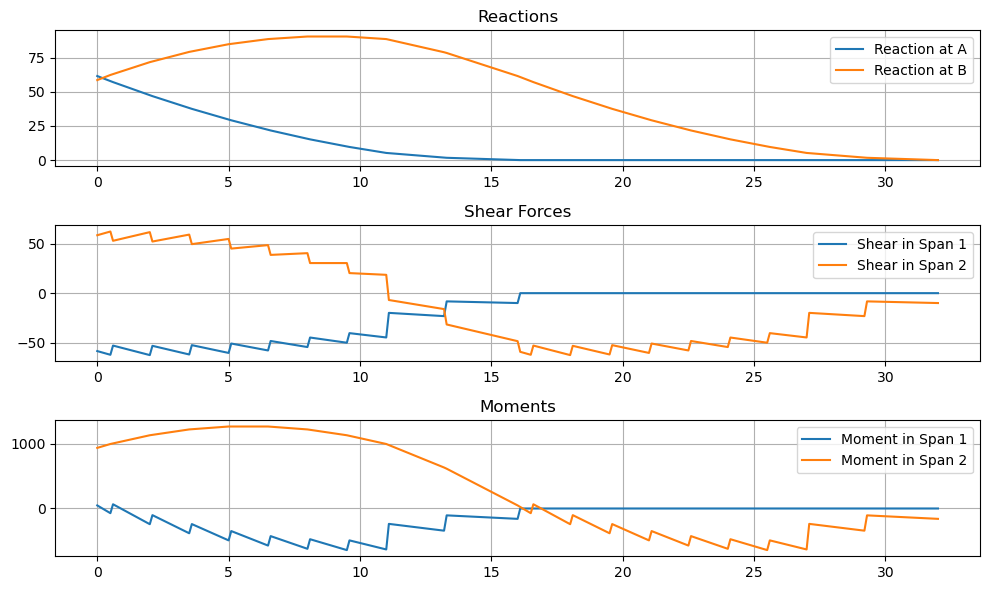

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_bridge_forces(
    bridge_length, span_length, truck_loads, axle_positions, trailer_loads, trailer_axle_spacing
):
    """
    Calculate the reaction forces, shear forces, and moments for a 2-span bridge with moving loads.

    Parameters:
        bridge_length (float): Total length of the bridge.
        span_length (float): Length of each span.
        truck_loads (list): List of loads on the truck's axles.
        axle_positions (list): List of distances of truck axles from the front axle.
        trailer_loads (list): List of loads on the trailer's axles.
        trailer_axle_spacing (float): Distance between consecutive trailer axles.

    Returns:
        results (dict): Dictionary with reaction forces, shear forces, and moments at each position.
    """
    # Setup parameters
    num_positions = int(bridge_length / 0.1) + 1  # Discretize movement
    positions = np.linspace(0, bridge_length, num_positions)

    # Initialize results
    reactions = np.zeros((2, num_positions))  # Reaction forces for each support
    shears = np.zeros((2, num_positions))  # Shear force for each span
    moments = np.zeros((2, num_positions))  # Moments for each span

    # Combine truck and trailer data
    total_loads = truck_loads + trailer_loads
    total_positions = axle_positions + [5 + i * trailer_axle_spacing for i in range(len(trailer_loads))]

    for i, position in enumerate(positions):
        # Calculate positions of axles relative to bridge start
        axle_global_positions = [position + pos for pos in total_positions]

        # Distribute loads to spans
        span_reactions = [0, 0]  # Reaction forces at supports
        for axle_pos, load in zip(axle_global_positions, total_loads):
            if 0 <= axle_pos <= span_length:
                span_reactions[0] += load * (span_length - axle_pos) / span_length
                span_reactions[1] += load * axle_pos / span_length
            elif span_length < axle_pos <= 2 * span_length:
                axle_pos_rel = axle_pos - span_length
                span_reactions[0] += 0  # No additional load on first span
                span_reactions[1] += load * (span_length - axle_pos_rel) / span_length

        # Store reaction forces
        reactions[:, i] = span_reactions

        # Calculate shear forces and moments for each span
        for span in range(2):
            if span == 0:
                left_support_reaction = span_reactions[0]
                span_load_positions = [pos for pos in axle_global_positions if 0 <= pos <= span_length]
                span_loads = [load for pos, load in zip(axle_global_positions, total_loads) if 0 <= pos <= span_length]
            else:
                left_support_reaction = span_reactions[1]
                span_load_positions = [pos - span_length for pos in axle_global_positions if span_length < pos <= 2 * span_length]
                span_loads = [load for pos, load in zip(axle_global_positions, total_loads) if span_length < pos <= 2 * span_length]

            shear_force = left_support_reaction - sum(span_loads)
            moment = left_support_reaction * span_length - sum(load * pos for load, pos in zip(span_loads, span_load_positions))

            shears[span, i] = shear_force
            moments[span, i] = moment

    return {
        "positions": positions,
        "reactions": reactions,
        "shears": shears,
        "moments": moments,
    }

# Define inputs
bridge_length = 32  # meters
span_length = 16  # meters
truck_loads = [10, 15, 15]  # tons
axle_positions = [0, 2.75, 5]  # meters
trailer_loads = [10] * 8  # tons, 8 axles
trailer_axle_spacing = 1.5  # meters

# Perform calculations
results = calculate_bridge_forces(
    bridge_length,
    span_length,
    truck_loads,
    axle_positions,
    trailer_loads,
    trailer_axle_spacing,
)

# Plot results
positions = results["positions"]
reactions = results["reactions"]
shears = results["shears"]
moments = results["moments"]

plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(positions, reactions[0], label="Reaction at A")
plt.plot(positions, reactions[1], label="Reaction at B")
plt.title("Reactions")
plt.legend()
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(positions, shears[0], label="Shear in Span 1")
plt.plot(positions, shears[1], label="Shear in Span 2")
plt.title("Shear Forces")
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(positions, moments[0], label="Moment in Span 1")
plt.plot(positions, moments[1], label="Moment in Span 2")
plt.title("Moments")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
